In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from geopandas import GeoDataFrame

In [117]:
uf = "CE"
uf_code = 23
anchor_y = 0.25  # RJ = 1; BA = 0.25; RS = 0.25
year = 2019

# import the municipalities shapes
mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(uf, uf))

# import the patients flow data
df = pd.read_csv("../data/"+uf+"/"+uf+"_sih_flow.csv")

# removing incoming/outcomming hospitalizations out from the choosen state
df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]
df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]

df.head()

<ipython-input-117-c747f8d10576>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]


year  uf_code  mun_cnes   mun_res  nhospadm_total
0  1994       23    230020  230020.0           266.0
1  1994       23    230020  230230.0             5.0
2  1994       23    230020  230425.0             5.0
3  1994       23    230020  230655.0            10.0
4  1994       23    230020  230780.0             4.0

## Municípios

In [118]:
imported_patients = df[['year', 'mun_cnes', 'nhospadm_total']].groupby(
    by = ['year', 'mun_cnes'], as_index = False).sum()
imported_patients = imported_patients.rename(columns={'nhospadm_total': 'imported'})

exported_patients = df[['year', 'mun_res', 'nhospadm_total']].groupby(
    by = ['year', 'mun_res'], as_index = False).sum()
exported_patients = exported_patients.rename(columns={'nhospadm_total': 'exported'})

internal_patients = df[df['mun_cnes'] == df['mun_res']][['year', 'mun_cnes', 'nhospadm_total']].groupby(
    by = ['year', 'mun_cnes'], as_index = False).sum()
internal_patients = internal_patients.rename(columns={'nhospadm_total': 'internal'})

In [119]:
mun_df = mun_df.merge(imported_patients[imported_patients.year == year], left_on='code', right_on='mun_cnes')
mun_df = mun_df.merge(exported_patients[exported_patients.year == year], left_on='code', right_on='mun_res')
mun_df = mun_df.merge(internal_patients[internal_patients.year == year], left_on='code', right_on='mun_cnes')

In [120]:
mun_df['lifo'] = mun_df['internal']/mun_df['imported']
mun_df['lofi'] = mun_df['internal']/mun_df['exported']

mun_df['regionalization'] = np.logical_and(mun_df['lifo']>=0.75, mun_df['lofi']>=0.75)
mun_df.head()

name    code  centroid_x  centroid_y  \
0      Acaraú  230020  -40.088133   -2.967898   
1    Acopiara  230030  -39.493842   -6.122031   
2      Aiuaba  230040  -40.298585   -6.605147   
3   Altaneira  230060  -39.699297   -6.985615   
4  Alto Santo  230070  -38.198640   -5.516685   

                                            geometry  year_x  mun_cnes_x  \
0  POLYGON ((-40.30984 -2.80769, -40.18533 -2.811...    2019      230020   
1  POLYGON ((-39.15631 -5.95731, -39.13062 -5.983...    2019      230030   
2  POLYGON ((-40.11801 -6.34845, -40.08480 -6.366...    2019      230040   
3  POLYGON ((-39.63350 -6.96878, -39.68063 -7.016...    2019      230060   
4  POLYGON ((-38.16672 -5.37783, -38.18962 -5.433...    2019      230070   

   imported  year_y   mun_res  exported  year  mun_cnes_y  internal      lifo  \
0    4047.0    2019  230020.0    3546.0  2019      230020    1959.0  0.484062   
1    1843.0    2019  230030.0    2519.0  2019      230030    1565.0  0.849159   
2     285.0    2019  230040.0    1099.0  2019      230040     270.0  0.947368   
3     196.0    2019  230060.0     617.0  2019      230060     196.0  1.000000   
4     146.0    2019  230070.0     846.0  2019      230070     140.0  0.958904   

       lofi  regionalization  
0  0.552453            False  
1  0.621278            False  
2  0.245678            False  
3  0.317666            False  
4  0.165485            False

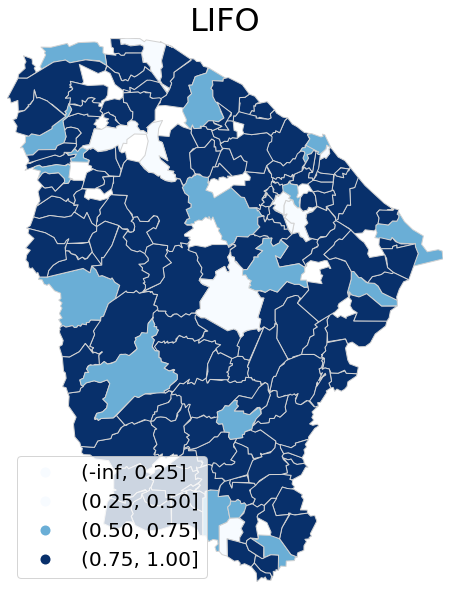

In [121]:
mun_df.plot(figsize=(15, 10),column='lifo', k=4, scheme='User_defined',
            cmap='Blues', edgecolor='lightgray', legend=True, classification_kwds=dict(bins=[0.25, 0.5, 0.75, 1]),
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(0,anchor_y),'fmt':"{:.2f}", 'fontsize':20})
plt.title('LIFO', fontsize=32)
plt.axis('off')
plt.margins(0)

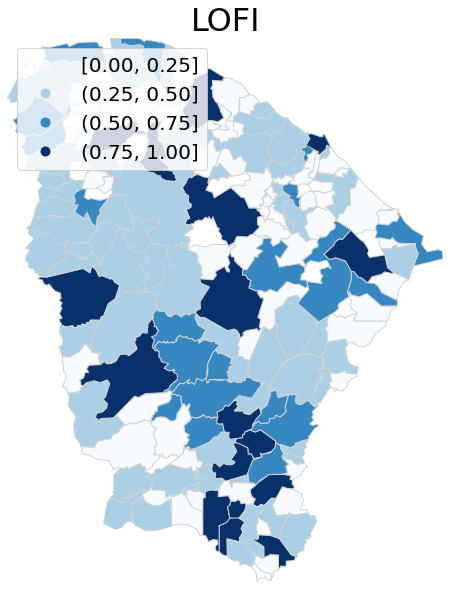

In [122]:
mun_df.plot(figsize=(15, 10),column='lofi', k=4, scheme='User_defined',
            cmap='Blues', edgecolor='lightgray', legend=True, classification_kwds=dict(bins=[0.25, 0.5, 0.75, 1]),
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(0,1),'fmt':"{:.2f}", 'fontsize':20})
plt.title('LOFI', fontsize=32)
plt.axis('off')
plt.margins(0)

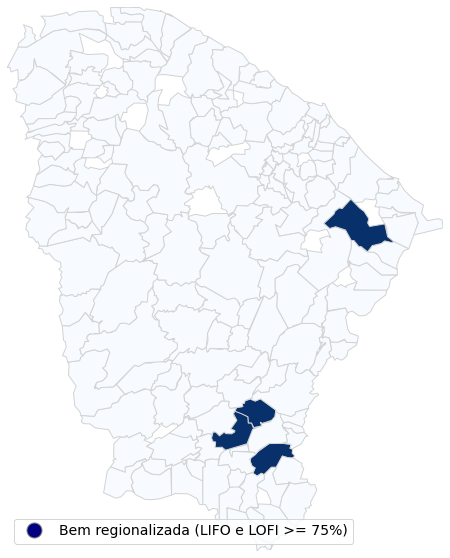

In [123]:
mun_df.plot(figsize=(15, 10),column='regionalization', k=2, cmap='Blues', edgecolor='lightgray')

circle = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor='navy', ms=15, mec='gray')]
plt.legend(circle, ['Bem regionalizada (LIFO e LOFI >= 75%)'], loc=3, fontsize=14)

# plt.title('Regionalization', fontsize=32)
plt.axis('off')
plt.margins(0)

## Regiões de Saúde

In [124]:
tmp_regions = gpd.read_file("../data/%s/regions/%s_regions_table_2017.csv"%(uf,uf))[['CD_MUN', 'region']]
tmp_regions.CD_MUN = tmp_regions.CD_MUN.astype('int64')

mun_df = mun_df.merge(tmp_regions, left_on='code', right_on='CD_MUN')
mun_df.head()

name    code  centroid_x  centroid_y  \
0      Acaraú  230020  -40.088133   -2.967898   
1    Acopiara  230030  -39.493842   -6.122031   
2      Aiuaba  230040  -40.298585   -6.605147   
3   Altaneira  230060  -39.699297   -6.985615   
4  Alto Santo  230070  -38.198640   -5.516685   

                                            geometry  year_x  mun_cnes_x  \
0  POLYGON ((-40.30984 -2.80769, -40.18533 -2.811...    2019      230020   
1  POLYGON ((-39.15631 -5.95731, -39.13062 -5.983...    2019      230030   
2  POLYGON ((-40.11801 -6.34845, -40.08480 -6.366...    2019      230040   
3  POLYGON ((-39.63350 -6.96878, -39.68063 -7.016...    2019      230060   
4  POLYGON ((-38.16672 -5.37783, -38.18962 -5.433...    2019      230070   

   imported  year_y   mun_res  exported  year  mun_cnes_y  internal      lifo  \
0    4047.0    2019  230020.0    3546.0  2019      230020    1959.0  0.484062   
1    1843.0    2019  230030.0    2519.0  2019      230030    1565.0  0.849159   
2     285.0    2019  230040.0    1099.0  2019      230040     270.0  0.947368   
3     196.0    2019  230060.0     617.0  2019      230060     196.0  1.000000   
4     146.0    2019  230070.0     846.0  2019      230070     140.0  0.958904   

       lofi  regionalization  CD_MUN             region  
0  0.552453            False  230020             Aracaú  
1  0.621278            False  230030             Iguatú  
2  0.245678            False  230040               Tauá  
3  0.317666            False  230060              Crato  
4  0.165485            False  230070  Limoeiro do Norte

In [125]:
mun_df

name    code  centroid_x  centroid_y  \
0             Acaraú  230020  -40.088133   -2.967898   
1           Acopiara  230030  -39.493842   -6.122031   
2             Aiuaba  230040  -40.298585   -6.605147   
3          Altaneira  230060  -39.699297   -6.985615   
4         Alto Santo  230070  -38.198640   -5.516685   
..               ...     ...         ...         ...   
158      Uruburetama  231380  -39.514538   -3.621278   
159           Uruoca  231390  -40.680352   -3.320912   
160          Varjota  231395  -40.493937   -4.167851   
161    Várzea Alegre  231400  -39.297850   -6.771793   
162  Viçosa do Ceará  231410  -41.136060   -3.546200   

                                              geometry  year_x  mun_cnes_x  \
0    POLYGON ((-40.30984 -2.80769, -40.18533 -2.811...    2019      230020   
1    POLYGON ((-39.15631 -5.95731, -39.13062 -5.983...    2019      230030   
2    POLYGON ((-40.11801 -6.34845, -40.08480 -6.366...    2019      230040   
3    POLYGON ((-39.63350 -6.96878, -39.68063 -7.016...    2019      230060   
4    POLYGON ((-38.16672 -5.37783, -38.18962 -5.433...    2019      230070   
..                                                 ...     ...         ...   
158  POLYGON ((-39.43097 -3.62271, -39.42050 -3.626...    2019      231380   
159  POLYGON ((-40.79438 -3.21804, -40.66906 -3.247...    2019      231390   
160  POLYGON ((-40.43291 -4.14007, -40.44871 -4.206...    2019      231395   
161  POLYGON ((-39.23833 -6.58392, -39.17858 -6.613...    2019      231400   
162  POLYGON ((-41.15935 -3.32640, -41.14908 -3.363...    2019      231410   

     imported  year_y   mun_res  exported  year  mun_cnes_y  internal  \
0      4047.0    2019  230020.0    3546.0  2019      230020    1959.0   
1      1843.0    2019  230030.0    2519.0  2019      230030    1565.0   
2       285.0    2019  230040.0    1099.0  2019      230040     270.0   
3       196.0    2019  230060.0     617.0  2019      230060     196.0   
4       146.0    2019  230070.0     846.0  2019      230070     140.0   
..        ...     ...       ...       ...   ...         ...       ...   
158      62.0    2019  231380.0    1326.0  2019      231380      59.0   
159       7.0    2019  231390.0     628.0  2019      231390       6.0   
160     332.0    2019  231395.0    1409.0  2019      231395     296.0   
161    3431.0    2019  231400.0    3744.0  2019      231400    2925.0   
162    2224.0    2019  231410.0    3906.0  2019      231410    2154.0   

         lifo      lofi  regionalization  CD_MUN             region  
0    0.484062  0.552453            False  230020             Aracaú  
1    0.849159  0.621278            False  230030             Iguatú  
2    0.947368  0.245678            False  230040               Tauá  
3    1.000000  0.317666            False  230060              Crato  
4    0.958904  0.165485            False  230070  Limoeiro do Norte  
..        ...       ...              ...     ...                ...  
158  0.951613  0.044495            False  231380          Itapipoca  
159  0.857143  0.009554            False  231390             Sobral  
160  0.891566  0.210078            False  231395             Sobral  
161  0.852521  0.781250             True  231400              Crato  
162  0.968525  0.551459            False  231410            Tianguá  

[163 rows x 19 columns]

In [126]:
reg_df = mun_df[['region', 'imported', 'exported', 'internal']].groupby(
    by = ['region'], as_index = False).sum()
reg_df = reg_df.rename(columns={'geometry_y': 'geometry'})
reg_df.head()

region  imported  exported  internal
0      Aracati    4082.0    4984.0    2575.0
1       Aracaú    6665.0   12452.0    4526.0
2     Baturité    4968.0    9087.0    2420.0
3  Brejo Santo   16658.0   18138.0   10646.0
4      Camocim    6018.0    7933.0    4151.0

In [127]:
reg_df['lifo'] = reg_df['internal']/reg_df['imported']
reg_df['lofi'] = reg_df['internal']/reg_df['exported']

reg_df['regionalization'] = np.logical_and(reg_df['lifo']>=0.75, reg_df['lofi']>=0.75)
reg_df.head()

region  imported  exported  internal      lifo      lofi  \
0      Aracati    4082.0    4984.0    2575.0  0.630818  0.516653   
1       Aracaú    6665.0   12452.0    4526.0  0.679070  0.363476   
2     Baturité    4968.0    9087.0    2420.0  0.487118  0.266315   
3  Brejo Santo   16658.0   18138.0   10646.0  0.639092  0.586945   
4      Camocim    6018.0    7933.0    4151.0  0.689764  0.523257   

   regionalization  
0            False  
1            False  
2            False  
3            False  
4            False

In [128]:
reg_df = reg_df.merge(gpd.read_file("../data/%s/regions/regions_2017.shp"%(uf)), 
                      left_on='region', right_on='name')
reg_df = GeoDataFrame(reg_df)

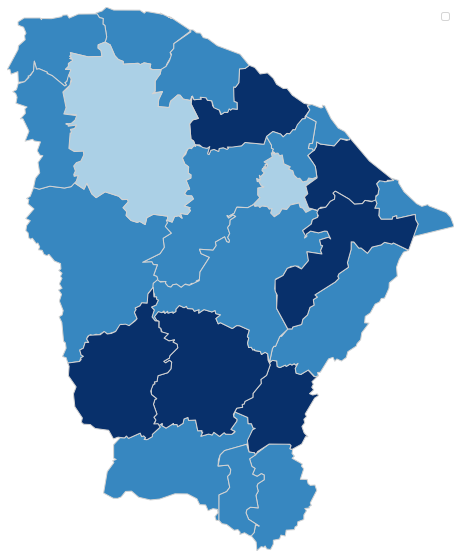

In [129]:
reg_df.plot(figsize=(10, 10), column='lifo', k=4, scheme='User_defined', vmin=0,
            cmap='Blues', edgecolor='lightgray', legend=True, classification_kwds=dict(bins=[0.25, 0.5, 0.75, 1]),
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0, 1.3),'fmt':"{:.2f}", 'fontsize':32,
                         'labels': ['(0.00, 0.25]', '(0.25, 0.50]', '(0.50, 0.75]', '(0.75, 1.00]']})

#plt.title('\nLIFO\n\n\n', fontsize=36)
plt.axis('off')
plt.legend('off')
plt.margins(0)
plt.savefig('./lifo_%s.png'%uf.lower(), transparent=True, bbox_inches='tight')

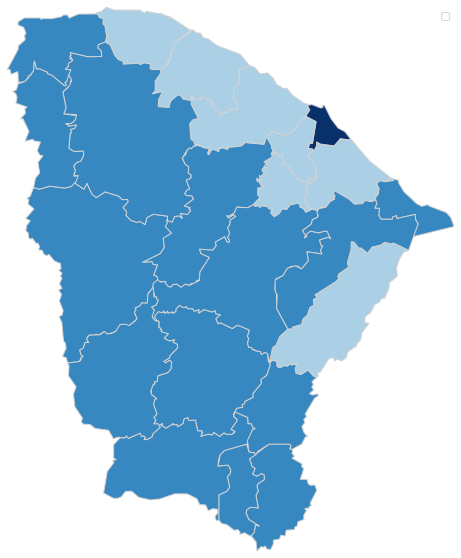

In [130]:
reg_df.plot(figsize=(10, 10),column='lofi', k=4, scheme='User_defined', vmin=0,
            cmap='Blues', edgecolor='lightgray', legend=True, classification_kwds=dict(bins=[0.25, 0.5, 0.75, 1]),
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0, 1.3),'fmt':"{:.2f}", 'fontsize':32,
                         'labels': ['(0.00, 0.25]', '(0.25, 0.50]', '(0.50, 0.75]', '(0.75, 1.00]']})
# plt.title('\nLOFI\n\n\n', fontsize=36)
plt.axis('off')
plt.legend('off')
plt.margins(0)
plt.savefig('./lofi_%s.png'%uf.lower(), transparent=True, bbox_inches='tight')

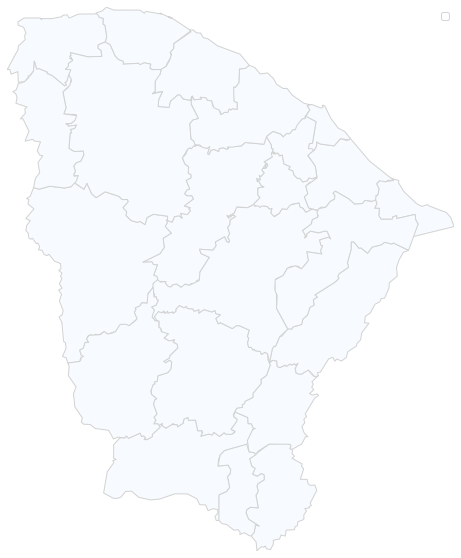

In [131]:
ax = reg_df.plot(figsize=(10, 10),column='regionalization', k=2, cmap='Blues', edgecolor='lightgray')
circle = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor='navy', ms=15, mec='gray')]
plt.legend(circle, ['Bem regionalizada \n(LIFO e LOFI >= 75%)'], fontsize=34, loc='upper left', bbox_to_anchor=(-0.05,-0.1))

#plt.title('\n\n', fontsize=36)
plt.axis('off')
plt.legend('off')
plt.margins(0)
plt.savefig('./reg_%s.png'%uf.lower(), transparent=True, bbox_inches='tight')